# Emotion recognition based on facial expression using CNN - Training and Validation

Our goal is to recognise human emotions based on changes in the facial expressions.

We will implement a model based on Convolutional Neural Network (CNN). The model that we chose is **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014. We will implement the **Inception v1** architecture from a paper called [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842), and then use another paper called [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167v3) in order to improve the model and speed up the training process.

We will use the [Face expression recognition dataset](https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset) available on Kaggle in order to train our model.

Before we start we need to install and import Tensorflow 2.0

In [ ]:
!pip install tensorflow-gpu==2.0

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


Since we are using Google Colab for this project, we decided to use Google Drive as storage for our data. We have downloaded the dataset from Kaggle as a `.zip` file and uploaded it to Google Drive. Now we need to mount the Google Drive to our notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Let's unzip the dataset from Google Drive to Google Colab.

**Note:** We do this only once per session!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE PER SESSION
!unzip -q "/content/drive/My Drive/Colab Notebooks/SML&DL Project/face-expression-recognition-dataset.zip" -d "dataset"

## Hyperparameters

In [ ]:
IMAGE_SIZE = 224          # from "Going Deeper with Convolutions" paper
BATCH_SIZE = 32           # from "Batch Normalization" paper
INITIAL_LRATE = 0.045     # from "Batch Normalization" paper (i.e. 0.0015 multiplied by a factor of 30)
L2_REGULARIZER = 0.00004  # from "Batch Normalization" paper (i.e. 0.0002 divided by a factor of 5)‬
MOMENTUM = 0.9            # from "Going Deeper with Convolutions" paper
EPOCHS = 50

## Data preparation

The dataset consists of 48x48 pixel *grayscale* images of human faces. The images are divided into two major categories: ***train*** and ***validation***. Each of those major categories is divided into 7 sub-categories: ***angry***, ***disgust***, ***fear***, ***happy***, ***neutral***, ***sad*** and ***surprise***.

Let's display some of the images in order to see what we are working with. We will display 5 images of each category from the train set.

In [ ]:
# define the project and data paths
project_path = "/content/drive/My Drive/Colab Notebooks/SML&DL Project/"
dataset_path = "dataset/images/images/"
train_path = dataset_path + "train/"
validation_path = dataset_path + "validation/"

Using TensorFlow backend.


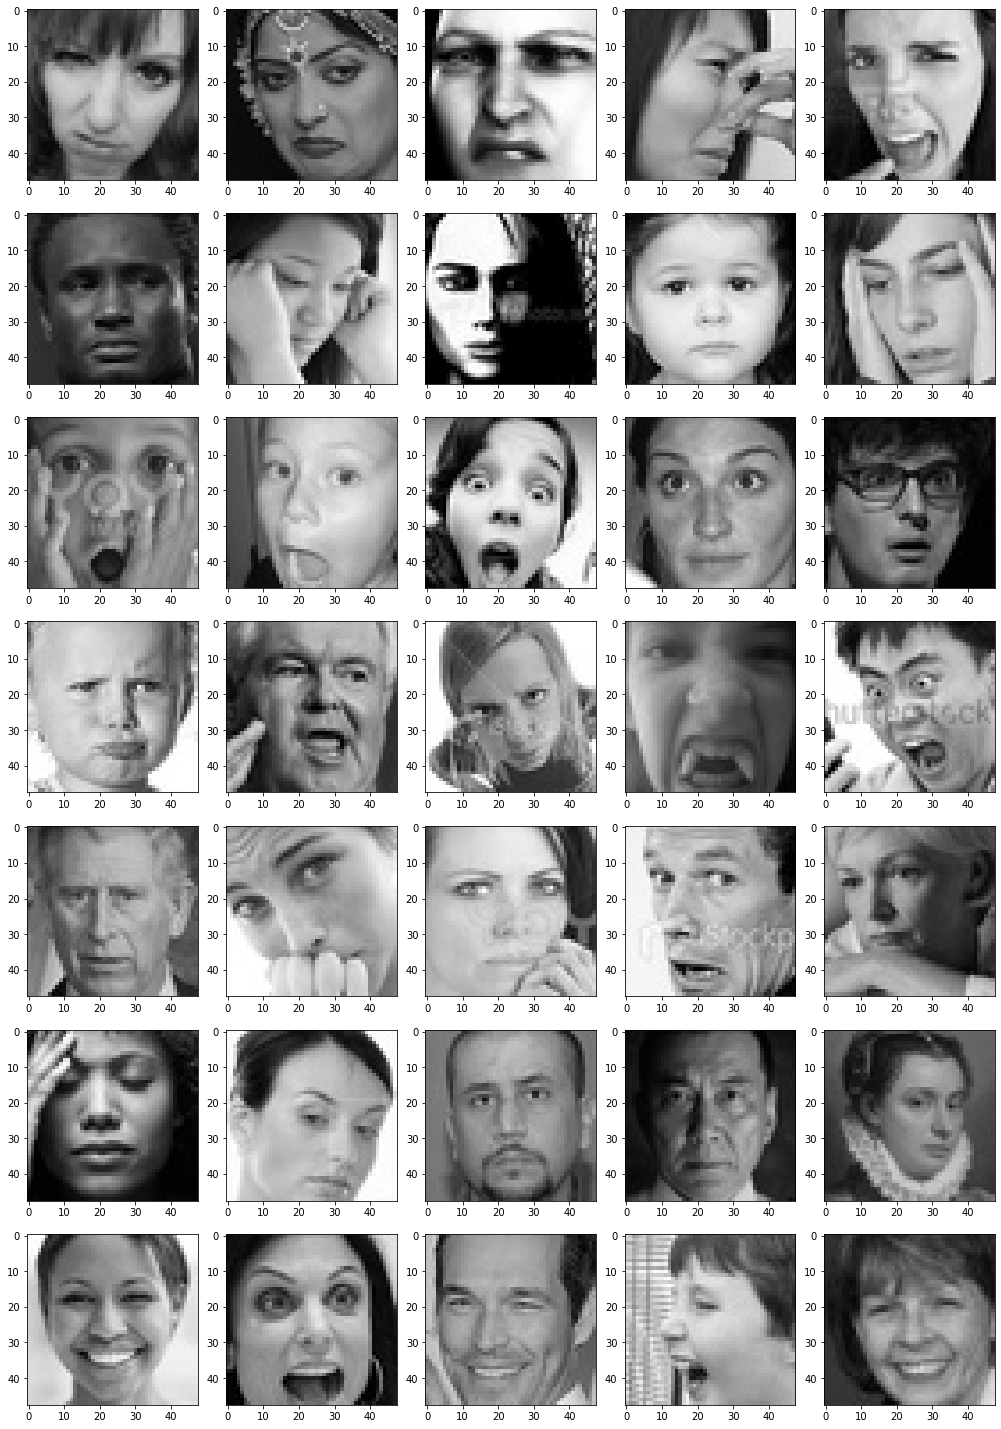

In [ ]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

plt.figure(0, figsize=(14, 20))
count = 0

# display sample images from the train directory
for dir_name in os.listdir(train_path):
    for i in range(1, 6):   # load 5 images of each category
        count = count + 1
        plt.subplot(7, 5, count)  # show the images in a 7x5 grid
        img = load_img(train_path + dir_name + "/" + os.listdir(train_path + dir_name)[i], 
                       target_size=(48, 48))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

Let's count the total number of images for each category in the train and validation sets.

In [ ]:
# count the number of images
TOTAL_TRAIN_IMAGES = 0
TOTAL_VALIDATION_IMAGES = 0

# Train set
print("Train set contains:")
for dir_name in os.listdir(train_path):
    temp_len = len(os.listdir(train_path + dir_name))
    print("\t" + str(temp_len) + " " + dir_name + " images")
    TOTAL_TRAIN_IMAGES = TOTAL_TRAIN_IMAGES + temp_len

# Validation set
print("\nValidation set contains:")
for dir_name in os.listdir(validation_path):
    temp_len = len(os.listdir(validation_path + dir_name))
    print("\t" + str(temp_len) + " " + dir_name + " images")
    TOTAL_VALIDATION_IMAGES = TOTAL_VALIDATION_IMAGES + temp_len

print("\nTotal number of images:", TOTAL_TRAIN_IMAGES + TOTAL_VALIDATION_IMAGES)
print("Total training images:", TOTAL_TRAIN_IMAGES)
print("Total validation images:", TOTAL_VALIDATION_IMAGES)

Train set contains:
	436 disgust images
	4938 sad images
	3205 surprise images
	3993 angry images
	4103 fear images
	4982 neutral images
	7164 happy images

Validation set contains:
	111 disgust images
	1139 sad images
	797 surprise images
	960 angry images
	1018 fear images
	1216 neutral images
	1825 happy images

Total number of images: 35887
Total training images: 28821
Total validation images: 7066


We will transform the images, so that they can fit in the input layer of our chosen model. Let's resize the images to 224x224 and change their color mode to rgb.

**Note:** We do this only once per session!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE PER SESSION
import cv2

dim = (IMAGE_SIZE, IMAGE_SIZE)

# transform the train dataset
for dir_name in os.listdir(train_path):
    for img_name in os.listdir(train_path + dir_name):
        img_path = train_path + dir_name + "/" + img_name

        # read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # resize and colorize the image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        colored = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

        # overwrite the image
        cv2.imwrite(img_path, colored)

# transform the validation dataset
for dir_name in os.listdir(validation_path):
    for img_name in os.listdir(validation_path + dir_name):
        img_path = validation_path + dir_name + "/" + img_name

        # read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # resize and colorize the image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        colored = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

        # overwrite the image
        cv2.imwrite(img_path, colored)

Let's print the image shape to see if the images are successfully transformed to 224x224 *rgb* images.

In [ ]:
import cv2
img = cv2.imread(validation_path + 'disgust/10053.jpg', cv2.IMREAD_UNCHANGED)
print('Original Dimensions: ', img.shape)

Original Dimensions:  (224, 224, 3)


Next we need to format the images into floating point tensors before feeding them to the network. Also, we need to rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

We will use the `ImageDataGenerator` class provided by `tf.keras`, since it automatically does all of that. It will also set up generators that convert these images into batches of tensors, which will be helpful when training the network. Also, since **Inception v1** has more than one output (i.e., it has a total of 3 outputs), we will need to define our own custom generator for multiple outputs.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255) # Generator for the training data
validation_generator = ImageDataGenerator(rescale=1./255) # Generator for the validation data

# custom generator for multiple outputs
def multiple_outputs(generator, image_dir, image_size, color_mode, batch_size, class_mode, shuffle, seed):
    gen = generator.flow_from_directory(image_dir,
                                        target_size=(image_size, image_size),
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        class_mode=class_mode,
                                        shuffle=shuffle,
                                        seed=seed)
    while True:
        gnext = gen.next()
        yield gnext[0], [gnext[1], gnext[1], gnext[1]]

train_data_generator = multiple_outputs(train_generator,
                                        train_path,
                                        image_size=IMAGE_SIZE,
                                        color_mode="rgb",
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=21)

validation_data_generator = multiple_outputs(validation_generator,
                                             validation_path,
                                             image_size=IMAGE_SIZE,
                                             color_mode="rgb",
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical',
                                             shuffle=True,
                                             seed=21)

We will also define an additional single data generator for the model evaluation, because the two auxiliary networks in **Inception v1** are discarded at inference time.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

evaluation_generator = ImageDataGenerator(rescale=1./255)

evaluation_data_generator = evaluation_generator.flow_from_directory(validation_path,
                                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                     color_mode="rgb",
                                                                     batch_size=157,
                                                                     class_mode='categorical',
                                                                     shuffle=False)

Found 7066 images belonging to 7 classes.


We are finished with the data preprocessing! Now we can proceed to actually implementing our model.

## Define the model

We will implement the **Inception v1** architecture from  [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842), and then use a paper called [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167v3) in order to improve the model and speed up the training process.

![GoogLeNet Architecture](https://miro.medium.com/max/2159/1*53uKkbeyzJcdo8PE5TQqqw.png)



> Figure 1: Inception-v1 architecture. This CNN has two auxiliary networks (which are discarded at inference time).



The above figure represents more clearly (at least in our opinion) the basic architecture of **Inception v1**. The figure was taken from https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d.

The changes made in **"Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"** paper compared to **"Going Deeper with Convolutions"** are the following:

1. ***Batch Normalization*** is applied to the input of each non-linearity.
2. ***Increased learning rate.*** The authors are able to achieve a training speedup from higher learning rates with no ill side effects. The initial learning rate is first increased from 0.0015 to 0.0075 (5 times larger than the original **Inception v1**), and then is further increased to 0.045 (30 times larger than the **Inception v1**).
3. ***Accelerated learning rate decay.*** The learning rate is lowered 6 times faster.
4. ***Removed Local Response Normalization.*** When using Batch Normalization, Local Response Normalization is not needed.
5. ***Removed Dropout Layers.*** According to the authors, removing the Dropout speeds up the training without increasing overfitting.
6. ***Reduced L<sub>2</sub> weight regularization.*** The weight of the L<sub>2</sub> loss on the model parameters is reduced by a factor of 5, which improves the accuracy on the validation data.
7. ***Shuffled training examples more thoroughly.*** The authors claim that by enabling a within-shard shuffling of the training data (which prevents the same examples from always appearing in a mini-batch together) they can achieve about 1% improved validation accuracy.

Other changes in the implementation include:

1. The first convolutional layer is replaced by a separable convolution layer with depth multiplier 8.
2. The 5×5 convolutional layers (inside the inception modules) are replaced by two consecutive 3×3 convolutional layers.
3. The number 28×28 inception modules (i.e. the first two inception modules after the Stem) is increased from 2 to 3.
4. Inside the inception modules we have either average pooling or maximum pooling (compared to only maximum pooling in **Inception v1**).
5. There are no across the board pooling layers between any two Inception modules.
6. In modules 3c and 4e we have maximum pooling/convolutional layers with stride 2 before the concatenation.
7. There are no fully-connected layers other than the top "softmax" layers.

In [ ]:
from tensorflow.keras import Model, layers, utils
from tensorflow.keras.regularizers import l2

Let's define a helper function called `InceptionModule` for the inception module, since we will need to call it a lot later.

In [ ]:
def InceptionModule(inputLayer, params, pull_type):
    _1x1 = params[0]
    _3x3reduce = params[1]
    _3x3 = params[2]
    _double3x3reduce = params[3]
    _double3x3 = params[4]
    _proj = params[5]

    inputNorm = layers.BatchNormalization()(inputLayer)

    # First row (i.e. with the double 3x3 convolution layers):
    double3x3conv1 = layers.Conv2D(filters=_double3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    double3x3norm2 = layers.BatchNormalization()(double3x3conv1)
    double3x3conv2 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm2)

    double3x3norm3 = layers.BatchNormalization()(double3x3conv2)
    double3x3conv3 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm3)

    # Second row (i.e. with the single 3x3 convolution layer):
    single3x3conv1 = layers.Conv2D(filters=_3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    single3x3norm2 = layers.BatchNormalization()(single3x3conv1)
    single3x3conv2 = layers.Conv2D(filters=_3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(single3x3norm2)

    # Third row (i.e. with the pooling layer):
    if pull_type == "max":
        poolType = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(inputNorm)

    elif pull_type == "avg":
        poolType = layers.AveragePooling2D(pool_size=7, strides=1, padding='same')(inputNorm)

    poolNorm = layers.BatchNormalization()(poolType)
    poolProj = layers.Conv2D(filters=_proj, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(poolNorm)

    # Fourth row (i.e. with the single 1x1 layer)
    single1x1conv = layers.Conv2D(filters=_1x1, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)

    return layers.Concatenate()([double3x3conv3, single3x3conv2, poolProj, single1x1conv])

We will also define a separate function for inception modules 3c and 4d. Notice that we have excluded the 1×1 convolution layer (i.e. the one on the forth row of the Inception module in Figure 1), since it has 0 number of filters, which is causing the environment to crash every time the code is executed. This module also has no 1×1 convolution layer (i.e. pool projection) after the maximum pooling. We also employ a stride 2 to the layers that are concatenated at the end of the module.

In [ ]:
def InceptionModule_PassThrough(inputLayer, params):
    _3x3reduce = params[0]
    _3x3 = params[1]
    _double3x3reduce = params[2]
    _double3x3 = params[3]

    inputNorm = layers.BatchNormalization()(inputLayer)

    # First row (i.e. with the double 3x3 convolution layers):
    double3x3conv1 = layers.Conv2D(filters=_double3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    double3x3norm2 = layers.BatchNormalization()(double3x3conv1)
    double3x3conv2 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm2)

    double3x3norm3 = layers.BatchNormalization()(double3x3conv2)
    double3x3conv3 = layers.Conv2D(filters=_double3x3, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(double3x3norm3)

    # Second row (i.e. with the single 3x3 convolution layer):
    single3x3conv1 = layers.Conv2D(filters=_3x3reduce, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(inputNorm)
    
    single3x3norm2 = layers.BatchNormalization()(single3x3conv1)
    single3x3conv2 = layers.Conv2D(filters=_3x3, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(single3x3norm2)

    # Third row (i.e. with the max pooling layer):
    maxPool = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(inputNorm)

    return layers.Concatenate()([double3x3conv3, single3x3conv2, maxPool])

Next we define all the layers in the Convolutional Neural Network.

In [ ]:
# Input Layer
inputLayer = layers.Input(name="input", shape=(224, 224, 3))

# Stem
stemNorm1 = layers.BatchNormalization()(inputLayer)
stemConv1 = layers.SeparableConv2D(filters=64, kernel_size=7, strides=2, padding='same', depth_multiplier=8, activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm1)
stemMaxPool1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(stemConv1)
stemNorm2 = layers.BatchNormalization()(stemMaxPool1)
stemConv2 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm2)
stemNorm3 = layers.BatchNormalization()(stemConv2)
stemConv3 = layers.Conv2D(filters=192, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(stemNorm3)
stemMaxPool2 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(stemConv3)

# Inception 3a
incept3a = InceptionModule(stemMaxPool2, [64, 64, 64, 64, 96, 32], pull_type="avg")

# Inception 3b
incept3b = InceptionModule(incept3a, [64, 64, 96, 64, 96, 64], pull_type="avg")

# Inception 3c (max pooling + pass through (320))
incept3c = InceptionModule_PassThrough(incept3b, [128, 160, 64, 96])

# Inception 4a
incept4a = InceptionModule(incept3c, [224, 64, 96, 96, 128, 128], pull_type="avg")

# Auxiliary Branch 1
auxAvgPool1 = layers.AveragePooling2D(pool_size=5, strides=3, padding='same')(incept4a)
auxNorm1 = layers.BatchNormalization()(auxAvgPool1)
auxConv1 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(auxNorm1)
auxFlatten1 = layers.Flatten()(auxConv1)
auxNorm3 = layers.BatchNormalization()(auxFlatten1)
auxOutput1 = layers.Dense(name="auxiliary_output_1", units=7, activation='softmax')(auxNorm3)

# Inception 4b
incept4b = InceptionModule(incept4a, [192, 96, 128, 96, 128, 128], pull_type="avg")

# Inception 4c
incept4c = InceptionModule(incept4b, [160, 128, 160, 128, 160, 128], pull_type="avg")

# Inception 4d
incept4d = InceptionModule(incept4c, [96, 128, 192, 160, 192, 128], pull_type="avg")

# Auxiliary Branch 2
auxAvgPool2 = layers.AveragePooling2D(pool_size=5, strides=3, padding='same')(incept4d)
auxNorm4 = layers.BatchNormalization()(auxAvgPool2)
auxConv2 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation='relu', kernel_regularizer=l2(l=L2_REGULARIZER))(auxNorm4)
auxFlatten2 = layers.Flatten()(auxConv2)
auxNorm6 = layers.BatchNormalization()(auxFlatten2)
auxOutput2 = layers.Dense(name="auxiliary_output_2", units=7, activation='softmax')(auxNorm6)

# Inception 4e (max pooling + pass through (576))
incept4e = InceptionModule_PassThrough(incept4d, [128, 192, 192, 256, 576])

# Inception 5a
incept5a = InceptionModule(incept4e, [352, 192, 320, 160, 224, 128], pull_type="avg")

# Inception 5b
incept5b = InceptionModule(incept5a, [352, 192, 320, 192, 224, 128], pull_type="max")

# Main Branch
mainAvgPool = layers.GlobalAveragePooling2D()(incept5b)
mainNorm2 = layers.BatchNormalization()(mainAvgPool)
mainOutput = layers.Dense(name="main_output", units=7, activation='softmax')(mainNorm2)

Now, we use the layers to create the model.

In [ ]:
model = Model(inputLayer, [mainOutput, auxOutput1, auxOutput2], name='Inception v1')

Let's show the model summary and plot the model using the `utils.plot_model` function from `tensorflow.keras`.

In [ ]:
model.summary()

Model: "Inception v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_56 (BatchNo (None, 224, 224, 3)  12          input[0][0]                      
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 112, 112, 64) 2776        batch_normalization_56[0][0]     
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 56, 56, 64)   0           separable_conv2d_1[0][0]         
_______________________________________________________________________________________

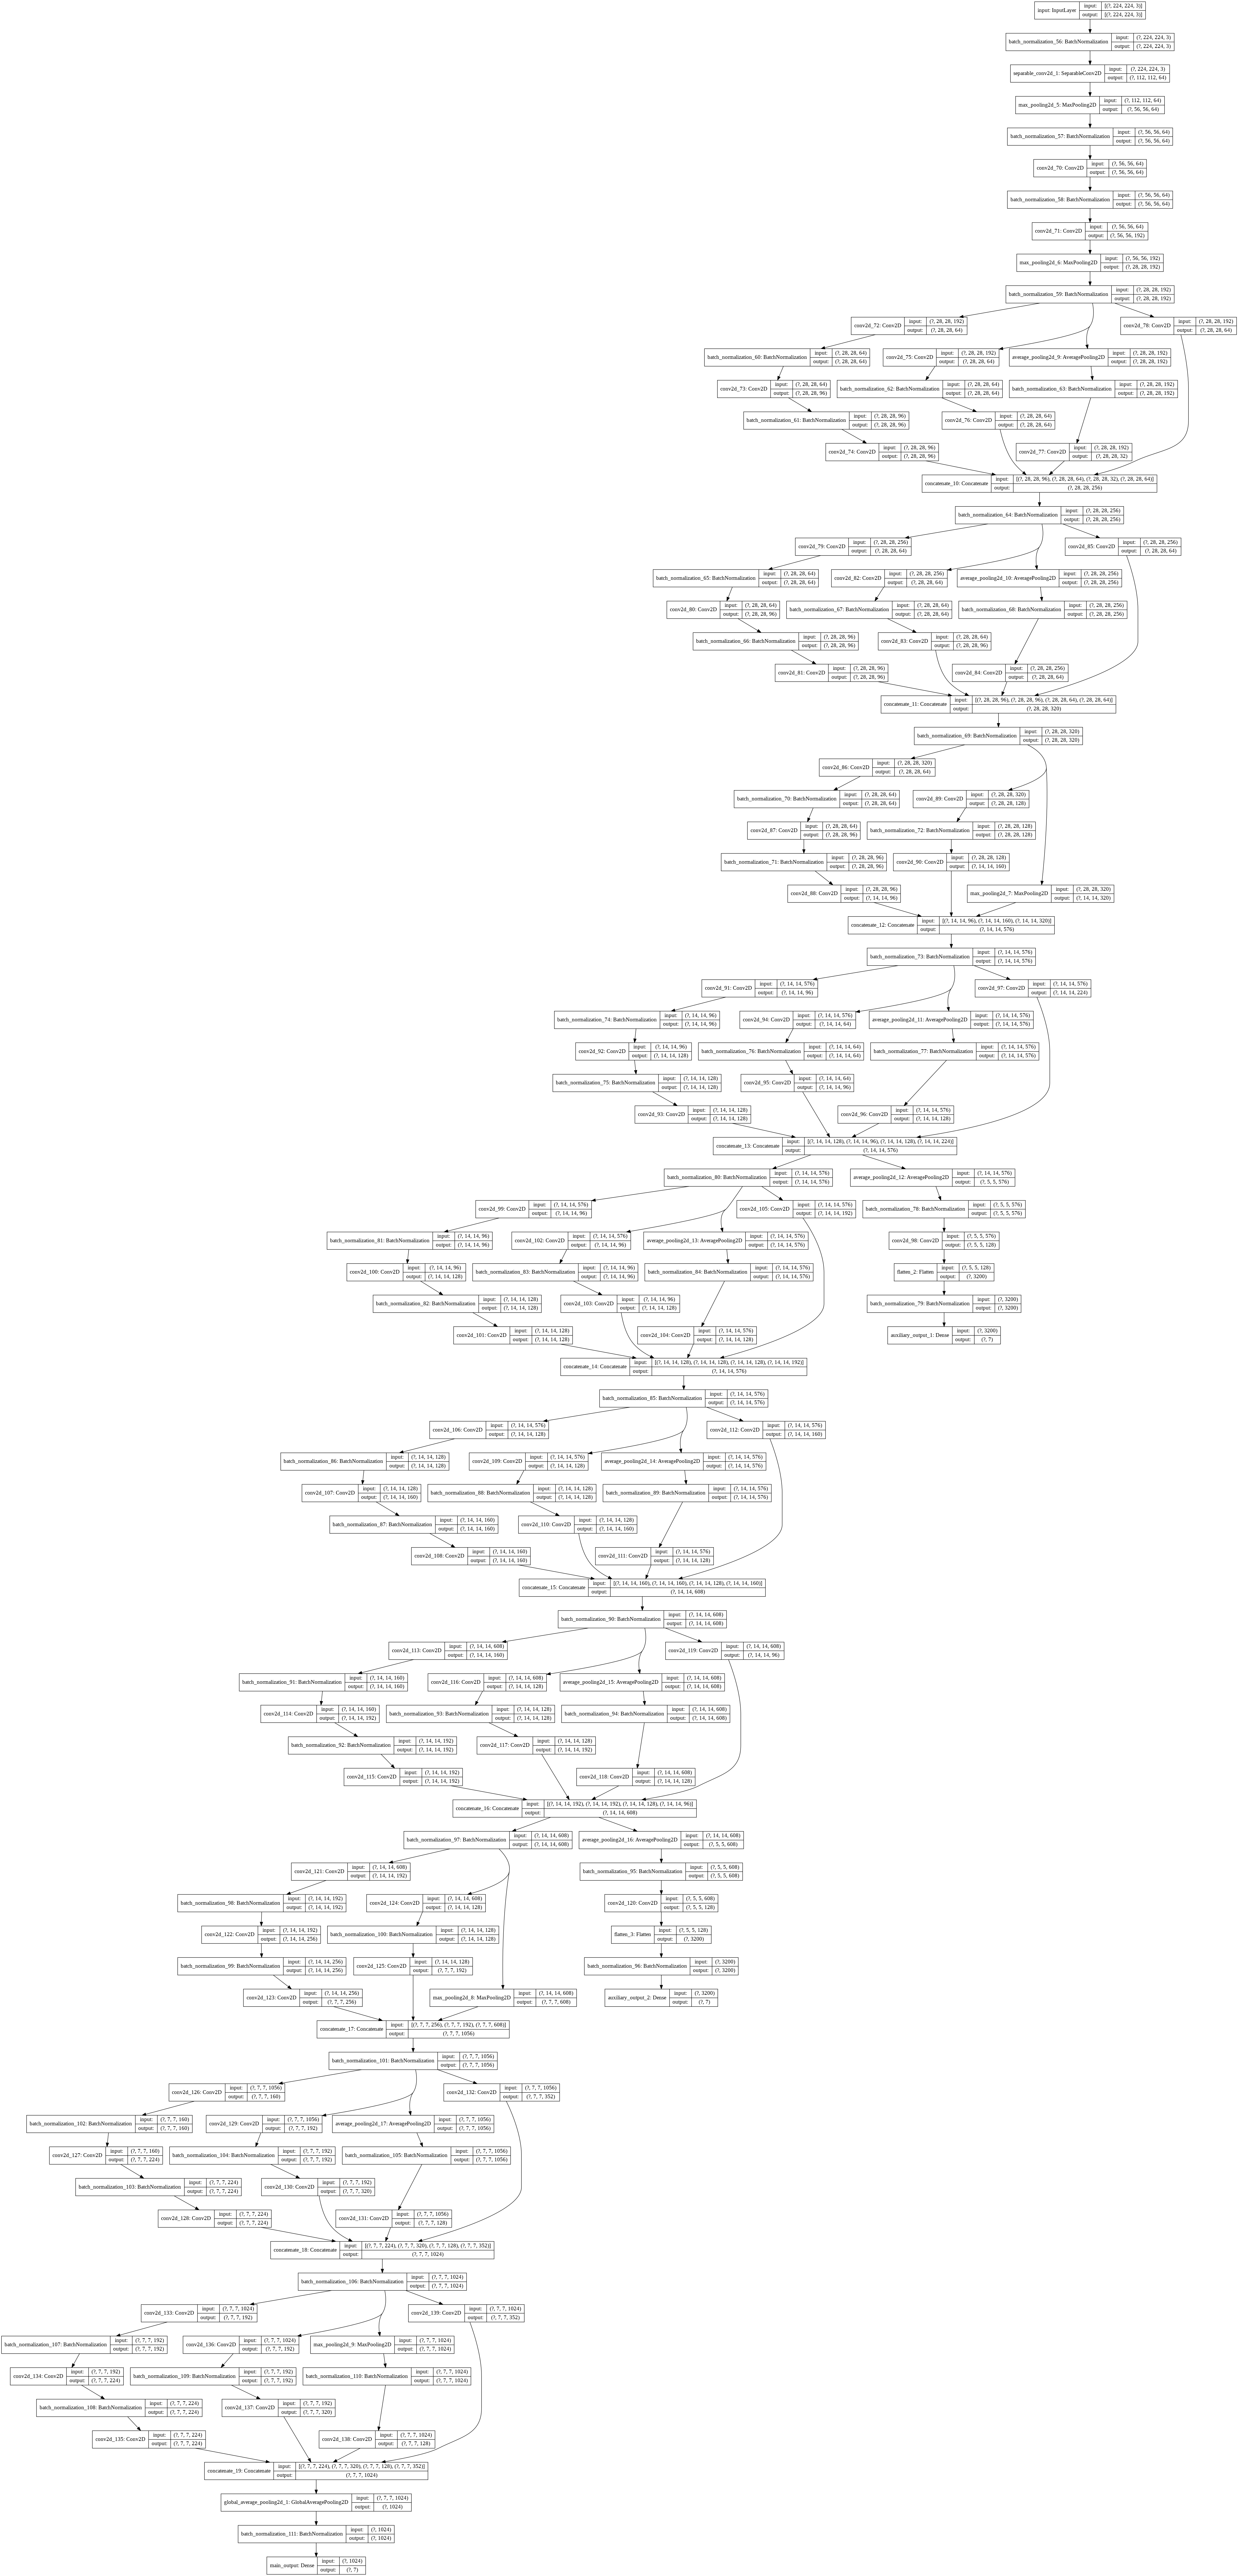

In [ ]:
utils.plot_model(model, project_path + 'Modified Inception v1 Model.png', show_shapes=True)

Next, we need to compile the model. We will use Stochastic Gradient Descent (SGD) with 0.9 momentum and a Drop-Based Learning Rate Schedule. In **Going Deeper with Convolutions** they decrease the learning rate by 4% every 8 epochs, while in **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift** the learning rate drops 6 times faster, so we chose to decrease the learning rate by 6% every 2 epochs. (More information on Learning Rate Schedule can be found  [here](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/).)

We will also use `ModelCheckpoint` in order to save our model weights after each epoch (only if the `val_loss` has decreased), and `CSVLogger` in order to save our training log/history after each epoch during training. We will be using the training log later when we are analyzing the results.

In [ ]:
import math
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger

# Custom Drop-Based Learning Rate Schedule
def step_decay(epoch, steps=100):
    init_lrate = INITIAL_LRATE
    drop = 0.94       # decrease the learning rate by 6%
    epochs_drop = 2   # decrease the learning rate every 2 epochs
    lrate = init_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

sgd = SGD(learning_rate=INITIAL_LRATE, momentum=MOMENTUM, nesterov=False)
model.compile(optimizer=sgd, 
              loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], 
              metrics=['accuracy'])

# Learning Rate Scheduler callback
lrate_callback = LearningRateScheduler(step_decay, verbose=1)

# Model Checkpoint callback
checkpoint_file_path = project_path + "saved_models/bn-inception-best-weights.hdf5"
checkpoint_callback = ModelCheckpoint(checkpoint_file_path, 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      save_weights_only=True, 
                                      verbose=1, 
                                      mode='min')

# CSV Logger callback for the training log
csv_logger_file_path = project_path + "saved_models/training_logs/bn-inception-training.log"
csv_logger_callback = CSVLogger(csv_logger_file_path, separator=',', append=True)

callbacks_list = [checkpoint_callback, lrate_callback, csv_logger_callback]

Finally, our model is ready! Next we need to fit the model.

## Train and evaluate

We will use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [ ]:
STEP_SIZE_TRAIN=TOTAL_TRAIN_IMAGES//BATCH_SIZE
STEP_SIZE_VALIDATION=TOTAL_VALIDATION_IMAGES//BATCH_SIZE

history = model.fit_generator(generator=train_data_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              callbacks=callbacks_list,
                              validation_data=validation_data_generator,
                              validation_steps=STEP_SIZE_VALIDATION)
                              # initial_epoch=25)   # continue training starting from the 26-th epoch


Epoch 00001: LearningRateScheduler reducing learning rate to 0.045.
Epoch 1/25
Found 28821 images belonging to 7 classes.
899/900 [============================>.] - ETA: 0s - loss: 6.6805 - main_output_loss: 2.5800 - auxiliary_output_1_loss: 5.5656 - auxiliary_output_2_loss: 3.7263 - main_output_accuracy: 0.2216 - auxiliary_output_1_accuracy: 0.2087 - auxiliary_output_2_accuracy: 0.2069Found 7066 images belonging to 7 classes.

Epoch 00001: val_loss improved from inf to 16.85588, saving model to /content/drive/My Drive/Colab Notebooks/SML&DL Project/saved_models/bn-inception-best-weights.hdf5
900/900 [==============================] - 660s 733ms/step - loss: 6.6792 - main_output_loss: 2.5796 - auxiliary_output_1_loss: 5.5641 - auxiliary_output_2_loss: 3.7248 - main_output_accuracy: 0.2216 - auxiliary_output_1_accuracy: 0.2088 - auxiliary_output_2_accuracy: 0.2069 - val_loss: 16.8559 - val_main_output_loss: 9.3369 - val_auxiliary_output_1_loss: 9.9970 - val_auxiliary_output_2_loss: 10.

Let's save our trained model, so that we can use it later. This includes both the model architecture and the model weights.

**Note:** Execute just one of the following two code cells!

In [ ]:
# Save the entire model to a HDF5 file (for the model trained with 25 epochs).
model_file_path = project_path + "saved_models/bn-inception-trained-with-25-epochs.h5"
model.save(model_file_path)

In [ ]:
# Save the entire model to a HDF5 file (for the model trained with 50 epochs).
model_file_path = project_path + "saved_models/bn-inception-trained-with-50-epochs.h5"
model.save(model_file_path)

We have trained the model with 25 and 50 epochs. Next, we need to discard the auxiliary branches. Let's load each individual model that we have saved so far and remove its auxiliary output branches.

**Note:** We execute following code just once and then save the resulting models to Google Drive!

In [ ]:
# EXECUTE THE FOLLOWING CODE JUST ONCE
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD

model_path = project_path + "saved_models/"

# load the models
batchnorm_25_model = load_model(model_path + "bn-inception-trained-with-25-epochs.h5")
batchnorm_50_model = load_model(model_path + "bn-inception-trained-with-50-epochs.h5")

# remove the auxiliary output layers
final_batchnorm_25_model = Model(batchnorm_25_model.input, batchnorm_25_model.outputs[0])
final_batchnorm_50_model = Model(batchnorm_50_model.input, batchnorm_50_model.outputs[0])

# compile the models
sgd = SGD(learning_rate=INITIAL_LRATE, momentum=MOMENTUM, nesterov=False)
final_batchnorm_25_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
final_batchnorm_50_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# save the new models to a HDF5 file.
model_file_path_25 = project_path + "saved_models/final_batchnorm_25_model.h5"
model_file_path_50 = project_path + "saved_models/final_batchnorm_50_model.h5"
final_batchnorm_25_model.save(model_file_path_25)
final_batchnorm_50_model.save(model_file_path_50)

Now that we are done with that and we have saved our models, let's load them and evaluate them on the validation data.

In [ ]:
from tensorflow.keras.models import load_model

model_path = project_path + "saved_models/"

# load the two models
final_batchnorm_25_model = load_model(model_path + "final_batchnorm_25_model.h5")
final_batchnorm_50_model = load_model(model_path + "final_batchnorm_50_model.h5")

# evaluate the two models
loss25, accuracy25 = final_batchnorm_25_model.evaluate_generator(evaluation_data_generator, steps=45, verbose=2)
loss50, accuracy50 = final_batchnorm_50_model.evaluate_generator(evaluation_data_generator, steps=45, verbose=2)

print("\nModel with 25 epochs:")
print("\tloss: ", loss25, "\n\taccuracy: ", accuracy25)
print("\nModel with 50 epochs:")
print("\tloss: ", loss50, "\n\taccuracy: ", accuracy50)

45/45 - 19s - loss: 6.0103 - accuracy: 0.5515
45/45 - 18s - loss: 5.3258 - accuracy: 0.5924

Model with 25 epochs:
	loss:  6.01026299794515 
	accuracy:  0.5514508

Model with 50 epochs:
	loss:  5.325783522923787 
	accuracy:  0.5923567


## Analyze the results

In [ ]:
import pandas as pd

# input paths for the log files
log_path = project_path + "saved_models/training_logs/bn-inception-training.log"

In [ ]:
N = 50  # number of rows to read from the logs (max: 50)

Last training loss:  3.218010069393177
Last validation loss:  6.218264549428767


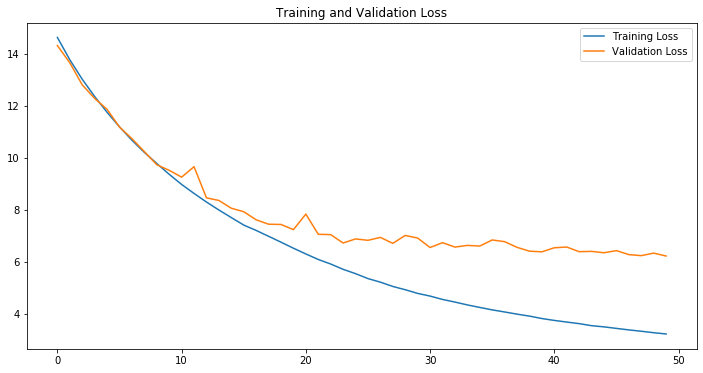

In [ ]:
# Read the first N rows of the training log
batchnorm_log = pd.read_csv(log_path, nrows=N)

# Read the training and validation loss columns
batchnorm_loss = batchnorm_log['loss']
batchnorm_val_loss = batchnorm_log['val_loss']

# Print the last available training and validation loss
last_batchnorm_loss = batchnorm_log.at[N-1, 'loss']
last_batchnorm_val_loss = batchnorm_log.at[N-1, 'val_loss']
print("Last training loss: ", last_batchnorm_loss)
print("Last validation loss: ", last_batchnorm_val_loss)

epochs_range = range(N)

# Print the diagram
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, batchnorm_loss, label='Training Loss')
plt.plot(epochs_range, batchnorm_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Last training accuracy:  0.98947513
Last validation accuracy:  0.59255046


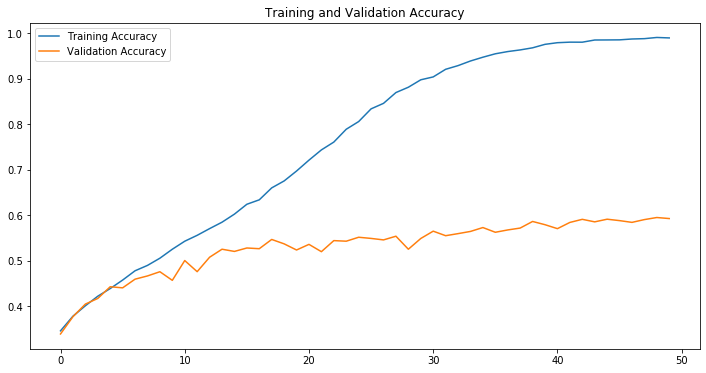

In [ ]:
# Read the first N rows of the training log
batchnorm_log = pd.read_csv(log_path, nrows=N)

# Read the training and validation loss columns
batchnorm_acc = batchnorm_log['main_output_accuracy']
batchnorm_val_acc = batchnorm_log['val_main_output_accuracy']

# Print the last available training and validation loss
last_batchnorm_acc = batchnorm_log.at[N-1, 'main_output_accuracy']
last_batchnorm_val_acc = batchnorm_log.at[N-1, 'val_main_output_accuracy']
print("Last training accuracy: ", last_batchnorm_acc)
print("Last validation accuracy: ", last_batchnorm_val_acc)

epochs_range = range(N)

# Print the diagram
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, batchnorm_acc, label='Training Accuracy')
plt.plot(epochs_range, batchnorm_val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()